In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Set path to google drive
path ="/content/drive/MyDrive/Colab Notebooks/Group_Project_2/AMZN_GOOG_MSFT_historical_data.csv"


In [4]:
# Read CSV file
data = pd.read_csv(path)

In [5]:
# To see data
data.head()

,Date,AMZN,MSFT,GOOGL
0,2016-01-04,636.73,54.790,759.41
1,2016-01-05,633.79,55.050,761.52
2,2016-01-06,632.81,54.075,759.30
3,2016-01-07,607.84,52.190,741.00
4,2016-01-08,607.23,52.330,730.92


In [6]:
# Prep. data frame
MS_df=data.drop(columns=["AMZN", "GOOGL"])
MS_df['Date'] = pd.to_datetime(MS_df['Date'])
MS_df.set_index('Date', inplace=True)
MS_df.head()

,MSFT
Date,
2016-01-04,54.790
2016-01-05,55.050
2016-01-06,54.075
2016-01-07,52.190
2016-01-08,52.330


In [7]:
# Slicing the date range
ms_df = MS_df.loc['2020-03-01':'2021-05-03']
ms_df.head()

,MSFT
Date,
2020-03-02,172.85
2020-03-03,164.38
2020-03-04,170.54
2020-03-05,166.24
2020-03-06,161.57


In [8]:
# Rename the column name
df_1=ms_df.rename(columns={"MSFT": "Close"})
df_1.head()

,Close
Date,
2020-03-02,172.85
2020-03-03,164.38
2020-03-04,170.54
2020-03-05,166.24
2020-03-06,161.57


In [9]:
# Reset index
df = df_1.reset_index()
df.head()

,Date,Close
0,2020-03-02,172.85
1,2020-03-03,164.38
2,2020-03-04,170.54
3,2020-03-05,166.24
4,2020-03-06,161.57


In [10]:
# Add exponential and rolling moving averages
df['EMA_5'] = df['Close'].ewm(5).mean().shift()
df['EMA_10'] = df['Close'].ewm(10).mean().shift()
df['SMA_5'] = df['Close'].rolling(5).mean().shift()
df['SMA_10'] = df['Close'].rolling(10).mean().shift()
df['SMA_15'] = df['Close'].rolling(15).mean().shift()
df['SMA_30'] = df['Close'].rolling(30).mean().shift()


In [12]:
# Set definition to calcluate RSI
def relative_strength_idx(df, n=14):
    close = df['Close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

df['RSI'] = relative_strength_idx(df).fillna(0)


In [13]:
# Add MACD (Moving Average Convergence Divergence)
EMA_12 = pd.Series(df['Close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['Close'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())
df

,Date,Close,EMA_5,EMA_10,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
0,2020-03-02,172.8500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-03-03,164.3800,172.850000,172.850000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
2,2020-03-04,170.5400,168.230000,168.413333,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
3,2020-03-05,166.2400,169.143846,169.190755,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
4,2020-03-06,161.5700,168.209076,168.344503,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
291,2021-04-27,262.0200,257.690625,253.026015,259.754,259.243,257.016000,246.610000,70.892181,6.054572,5.947225
292,2021-04-28,254.7100,258.412188,253.843650,260.502,259.596,257.959333,247.517000,52.198969,5.347808,5.827342
293,2021-04-29,252.4600,257.795156,253.922409,259.322,259.476,258.280667,248.084333,44.839204,4.553645,5.572602
294,2021-04-30,252.2700,256.905964,253.789463,258.374,258.766,258.227333,248.593333,44.359523,3.864387,5.230959


In [14]:
# Split stock data frame into three subsets: training ( 95% ), validation ( 2.5% ) and test ( 2.5% ) sets

test_size  = 0.025
valid_size = 0.025

test_split_idx  = int(df.shape[0] * (1-test_size))
valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))

train_df  = df.loc[:valid_split_idx].copy()
valid_df  = df.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = df.loc[test_split_idx+1:].copy()

train_df.head()

,Date,Close,EMA_5,EMA_10,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
0,2020-03-02,172.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-03-03,164.38,172.850000,172.850000,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2,2020-03-04,170.54,168.230000,168.413333,NaN,NaN,NaN,NaN,0.0,NaN,NaN
3,2020-03-05,166.24,169.143846,169.190755,NaN,NaN,NaN,NaN,0.0,NaN,NaN
4,2020-03-06,161.57,168.209076,168.344503,NaN,NaN,NaN,NaN,0.0,NaN,NaN


In [15]:
# Drop unnecessary columns

train_df = train_df.drop(columns=["Date"])
valid_df = valid_df.drop(columns=["Date"])
test_df  = test_df.drop(columns=["Date"])

train_df.head()

,Close,EMA_5,EMA_10,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
0,172.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,164.38,172.850000,172.850000,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2,170.54,168.230000,168.413333,NaN,NaN,NaN,NaN,0.0,NaN,NaN
3,166.24,169.143846,169.190755,NaN,NaN,NaN,NaN,0.0,NaN,NaN
4,161.57,168.209076,168.344503,NaN,NaN,NaN,NaN,0.0,NaN,NaN


In [16]:
# Set X_train, y_train, X_valid, y_valid, X_test, and y_test
y_train = train_df['Close'].copy()
X_train = train_df.drop(['Close'], 1)

y_valid = valid_df['Close'].copy()
X_valid = valid_df.drop(['Close'], 1)

y_test  = test_df['Close'].copy()
X_test  = test_df.drop(['Close'], 1)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   EMA_5        281 non-null    float64
 1   EMA_10       281 non-null    float64
 2   SMA_5        277 non-null    float64
 3   SMA_10       272 non-null    float64
 4   SMA_15       267 non-null    float64
 5   SMA_30       252 non-null    float64
 6   RSI          281 non-null    float64
 7   MACD         257 non-null    float64
 8   MACD_signal  249 non-null    float64
dtypes: float64(9)
memory usage: 20.0 KB


In [17]:
# Set the parameters
parameters = {
  # Number of boosted trees to fit
     'n_estimators': [1],  
  # boosting learning rate
     'learning_rate': [0.001], 
  # Maximum tree depth for base learnes    
     'max_depth': [5],        
    'random_state': [1]
}

eval_set = [(X_train, y_train), (X_valid, y_valid)]

model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False, parameters=parameters)
# objective='reg:squarederror' regression with squared loss

In [18]:
# Fit the model
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1,
             eval_set=[(          EMA_5      EMA_10    SMA_5  ...        RSI      MACD  MACD_signal
0           NaN         NaN      NaN  ...        NaN       NaN          NaN
1    172.850000  172.850000      NaN  ...   0.000000       NaN          NaN
2    168.230000  168.413333      NaN  ...   0.000000       NaN          NaN
3    169.143846  169.190755      NaN  ...   0.000000       NaN          NaN
4    168.209076  168.344503      NaN  ...   0.000000       NaN          NaN
..          ...         ...      ...  .....
             gamma=0, importance_type='gain', learning_rate=0.1,
             max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
             n_estimators=100, n_jobs=1, nthread=None,
             objective='reg:squarederror',
             parameters={'learning_rate': [0.001], 'max_depth': [5],
                         'n_estimators': [1],

In [19]:
# Run predict
y_pred = model.predict(X_test)

In [21]:
# Define model evaluation method
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
cv = RepeatedKFold(n_splits=7, n_repeats=3, random_state=1)
# Evaluate model to calculate mean absolute error
scores = cross_val_score(model, X_test, y_pred, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# Force scores to be positive
scores = np.absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )
# Calculate R2 (mean_square_error) to evaluate predictions
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')

Mean MAE: 2.213 (3.479)
mean_squared_error = 113.21746445245738


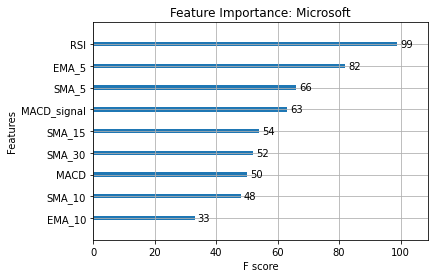

In [27]:
# Plot feature importance
plot_importance(model, title ='Feature Importance: Microsoft');

In [23]:
# Prep to create a dataframe for the predicted value and actual closing price
predicted_prices = df.loc[test_split_idx+1:].copy()
predicted_prices['Close'] = y_pred
predicted_prices.Date
date_pred=pd.DataFrame(predicted_prices.Date)
date_pred=date_pred.reset_index(drop=True)
# Make the predicted value to DataFrame
amazon_pred = pd.DataFrame(y_pred)
# Make X_test value to DataFrame
actual=pd.DataFrame(y_test) 
actual_f=actual.reset_index(drop=True)
actual_f
# combine date, closing price and predict value
actual_pred = pd.concat([date_pred, actual_f, amazon_pred], axis=1)

# Set the column name for the Predicted value
actual_pred.rename( columns={0 :'Pred'}, inplace=True )
# calculate the difference and squar of diff.
actual_pred['Diff'] = actual_pred['Close'] - actual_pred['Pred']
actual_pred['Square'] = actual_pred['Diff']**2
actual_pred

,Date,Close,Pred,Diff,Square
0,2021-04-23,261.1300,252.920502,8.209498,67.395862
1,2021-04-26,261.5500,254.356461,7.193539,51.747010
2,2021-04-27,262.0200,252.969864,9.050136,81.904964
3,2021-04-28,254.7100,241.553864,13.156136,173.083927
4,2021-04-29,252.4600,241.288712,11.171288,124.797686
5,2021-04-30,252.2700,241.105118,11.164882,124.654595
6,2021-05-03,251.8801,238.882477,12.997623,168.938209


In [24]:
# Calculate the total of diffeences
column_sum = actual_pred['Diff'].sum()
print(f"Total differences {column_sum}")
# Calculate the mean squared error
MSE = actual_pred['Square'].mean()
print(f"Mean Squared Error {MSE}")
# Compute the root-mean-square
rms = np.sqrt(MSE)
print(f"Root Mean Square {rms}")
# calculate the mean of the closing prices
ClosingPrice = actual_pred['Close'].mean()
print(f"Mean Closing Price {ClosingPrice}")

Total differences 72.94310415039064
Mean Squared Error 113.21746445245738
Root Mean Square 10.640369563716167
Mean Closing Price 256.57430000000005


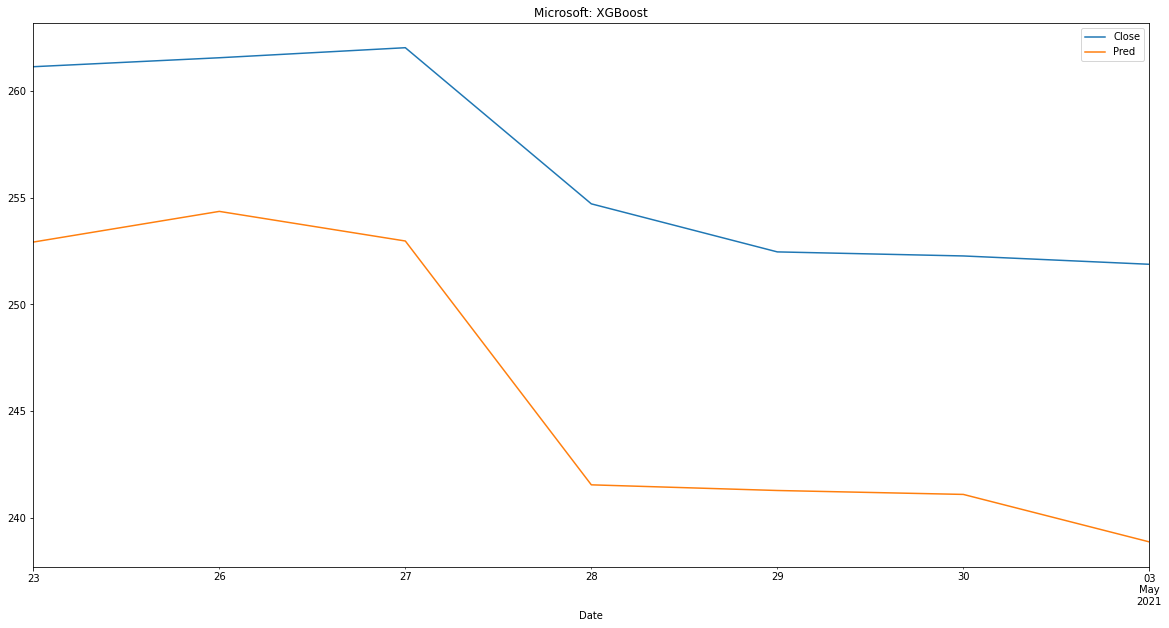

In [25]:
# Plot the closing price and predicted price
actual_pred.plot.line(x="Date", y=["Close", "Pred"],title="Microsoft: XGBoost", figsize=(20,10));

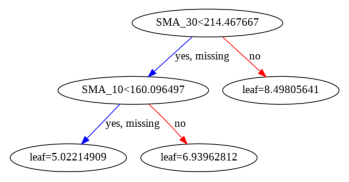

In [26]:
# Plot tree
plot_tree(model, num_trees=10);